In [7]:
import tensorflow as tf
import os
import time
from matplotlib import pyplot as plt
from IPython import display
import imageio
import numpy as np
import cv2
from time import sleep
from tqdm import tqdm_notebook as tqdm

In [14]:
BUFFER_SIZE = 400
BATCH_SIZE = 16
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMAGE_SIZE = 256
BASE_INPUT_PATH = "../" 

In [9]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_png(image)
    w = tf.shape(image)[1]
    w = w // 2
    Depth_image = image[:, w:, :]
    RGB_image = image[:, :w, :]
    RGB_image = tf.cast(RGB_image, tf.float32)
    Depth_image = tf.cast(Depth_image, tf.float32)
    return RGB_image, Depth_image

In [10]:
def resize(RGB_image, Depth_image, height, width):
    RGB_image = tf.image.resize(RGB_image, [height, width],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    Depth_image = tf.image.resize(Depth_image, [height, width],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return RGB_image, Depth_image
def random_crop(RGB_image, Depth_image):
    stacked_image = tf.stack([RGB_image, Depth_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
    return cropped_image[0], cropped_image[1]
def normalize(RGB_image, Depth_image):
    RGB_image = (RGB_image / 127.5) - 1
    Depth_image = (Depth_image / 127.5) - 1
    return RGB_image, Depth_image
@tf.function()
def random_jitter(RGB_image, Depth_image):
    RGB_image, Depth_image = resize(RGB_image, Depth_image, 286, 286)
    RGB_image, Depth_image = random_crop(RGB_image, Depth_image)
    if tf.random.uniform(()):
        RGB_image = tf.image.flip_left_right(RGB_image)
        Depth_image = tf.image.flip_left_right(Depth_image)
    return RGB_image, Depth_image

In [11]:
def load_image_test_raw(image_file):
    raw_image = tf.io.read_file(image_file)
    raw_image = tf.image.decode_png(raw_image)
    raw_image = tf.cast(raw_image, tf.float32)
    raw_image = tf.image.resize(raw_image, [256, 256],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    raw_image = (raw_image / 127.5) - 1
    return raw_image

In [12]:
test_raw_dataset = tf.data.Dataset.list_files(BASE_INPUT_PATH +'testing_raw/*.png')
test_raw_dataset = test_raw_dataset.map(load_image_test_raw)
test_raw_dataset = test_raw_dataset.batch(BATCH_SIZE)
OUTPUT_CHANNELS = 3

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [17]:
!dir checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

 磁碟區 E 中的磁碟是 Data
 磁碟區序號:  7297-1518

 E:\pythonwork\depth_gan\Image-Depth-Prediction 的目錄



找不到檔案


In [19]:
def generate_raw_images(model, test_input):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(5,5))
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

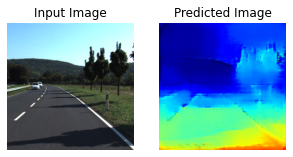

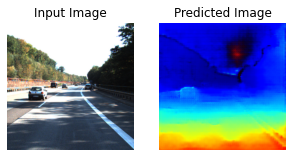

Time taken for every 2 is 0.7176764011383057 sec



In [21]:
startt = time.time()
for inp in test_raw_dataset.take(2):
  generate_raw_images(generator, inp)
print ('Time taken for every {} is {} sec\n'.format(2,time.time()-startt))